In [ ]:
import os
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from CodebleuCalculator import codebleu_score_calculator

In [ ]:
def validate_config(config: dict):
    required_keys = [
    "language", "summarize_codebase", "codebase_readme_path", "files_to_summarize_paths", "codebase_summary_prompt_template", "codebase_summary_prompt_save_path", "codebase_summary_save_path", "function_description_prompt_template", "function_description_prompt_save_path", "function_description_save_path",  "function_generation_prompt_template_type1", "function_generation_prompt_type1_save_path", "function_generation_prompt_template_type2", "function_generation_prompt_type2_save_path", "function_generation_prompt_template_type3", "function_generation_prompt_type3_save_path", "chosen_function_path", "chosen_function", "original_function_save_path", "example_function_description1", "example_function_code1", "example_function_description2", "example_function_code2", "generated_function_type1_save_dir", "generated_function_type2_save_dir", "generated_function_type3_save_dir", "run_codebleu", "codebleu_type1_save_dir", "codebleu_type2_save_dir", "codebleu_type3_save_dir"     
    ]
    
    for key in required_keys:
        if key not in config:
            raise ValueError(f"Missing required key: {key}")


In [ ]:
def read_config_files_index(file_index_path: str):
    with open(file_index_path, 'r') as f:
        remaining_confs_paths = f.read().splitlines()

    remaining_confs = []
    for cf_path in remaining_confs_paths:
        conf = json.load(open(cf_path))
        try:
            validate_config(conf)
            remaining_confs.append(conf)
        except Exception as e:
            print(f"Error in {cf_path}: {e}")
    
    return remaining_confs


In [ ]:
def get_function_paths(config:dict, model_name: str, prompt_type: str, generation_num: int=1):
    """Get the path to original code and generated code for a specific model and prompt type.

    Args:
        config (dict): The experiment config 
        model_name (str): name of model, one of ["GPT-3_5-Turbo", "GPT-4", "DeepSeek-Coder-V2", "CodeQwen1_5-7B-Chat", "Artigenz-Coder-DS-6_7B"]
        prompt_type (str): prompt type, one of ["type1", "type2", "type3"]
        generation_num (int): This is the generation_num th generated function. Defaults to 1.
    """
    generated_function_save_dirs = {
        "type1": config['generated_function_type1_save_dir'],
        "type2": config['generated_function_type2_save_dir'],
        "type3": config['generated_function_type3_save_dir']
    }

    filename = config['chosen_function'].split(".")
    generated_function_save_filename = f"{filename[0]}_{generation_num}.{filename[1]}"
    generated_function_save_path = f"{generated_function_save_dirs[prompt_type]}/{model_name}/GENERATED-{generated_function_save_filename}"
    original_function_save_path = config['original_function_save_path']

    return {"original": original_function_save_path, "generated": generated_function_save_path}


In [ ]:
def get_name(config):
    repo, func = config['original_function_save_path'].split('/')[:-1]
    return repo, func[-1]


In [ ]:
configs = read_config_files_index("remaining_confs.txt")
print(f"read {len(configs)} config files")

read 10 config files


In [ ]:
print(configs[0])

{'language': 'JS', 'summarize_codebase': True, 'codebase_readme_path': 'craftship_codebox-npm/README.md', 'files_to_summarize_paths': 'craftship_codebox-npm/function1/context-files-paths.txt', 'codebase_summary_prompt_template': 'prompt-templates/codebase-summarization-prompt-template.txt', 'codebase_summary_prompt_save_path': 'craftship_codebox-npm/function1/prompts/codebase-summarization-prompt.txt', 'codebase_summary_save_path': 'craftship_codebox-npm/function1/codebase-summary.txt', 'function_description_prompt_template': 'prompt-templates/function-description-prompt-template.txt', 'function_description_prompt_save_path': 'craftship_codebox-npm/function1/prompts/function-description-prompt.txt', 'function_description_save_path': 'craftship_codebox-npm/function1/function-description.txt', 'function_generation_prompt_template_type1': 'prompt-templates/function-generation-prompt-template/type1.txt', 'function_generation_prompt_type1_save_path': 'craftship_codebox-npm/function1/prompts

In [ ]:
model_names = [
    "GPT-3_5-Turbo", 
    "GPT-4", 
    "DeepSeek-Coder-V2", 
    "CodeQwen1_5-7B-Chat", 
    "Artigenz-Coder-DS-6_7B"
]
type_names = ["type1", "type2", "type3"]
languages = {
    "JS": "javascript",
    "python": "python",
    "TS": "javascript"
}

In [ ]:
codebleu_scores = []

for conf in tqdm(configs, desc="Configs"):
    for model_name in tqdm(model_names, desc="models", leave=False):
        for prompt_type in tqdm(type_names, desc="prompt types", leave=False):
            if prompt_type == "type3" and conf["generated_function_type3_save_dir"] == "":
                # skip type3 prompt because it doesnt exist
                continue

            paths = get_function_paths(conf, model_name, prompt_type)
            original_path, generated_path = paths['original'], paths['generated']
            repo, func_num = get_name(conf)

            codebleu_score = codebleu_score_calculator(
                        original_path,
                        generated_path,
                        languages[conf['language']]
                    )
            
            codebleu_scores.append([repo, func_num, prompt_type, model_name, codebleu_score['codebleu']])

In [ ]:
codebleu_scores_df = pd.DataFrame(codebleu_scores, columns=["Repo", "FunctionNumber", "PromptType", "Model", "CodeBLEU"])

In [ ]:
codebleu_scores_df.head()

In [5]:
codebleu_scores_df = pd.read_csv("codebleu_scores.csv")
codebleu_scores_df.head()

<IPython.core.display.Javascript object>

,Repo,FunctionNumber,PromptType,Model,CodeBLEU
0,craftship_codebox-npm,1,type1,GPT-3_5-Turbo,0.206217
1,craftship_codebox-npm,1,type2,GPT-3_5-Turbo,0.189734
2,craftship_codebox-npm,1,type3,GPT-3_5-Turbo,0.216253
3,craftship_codebox-npm,1,type1,GPT-4,0.214215
4,craftship_codebox-npm,1,type2,GPT-4,0.233742


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style(style="darkgrid")
sns.set_palette("Set2")

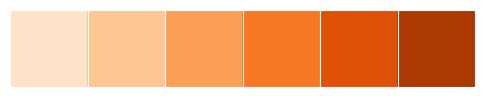

In [4]:
palette = sns.color_palette("Oranges", 6, as_cmap=False)

sns.palplot(palette)
plt.show()

In [55]:
# get average codebleu score for each repo


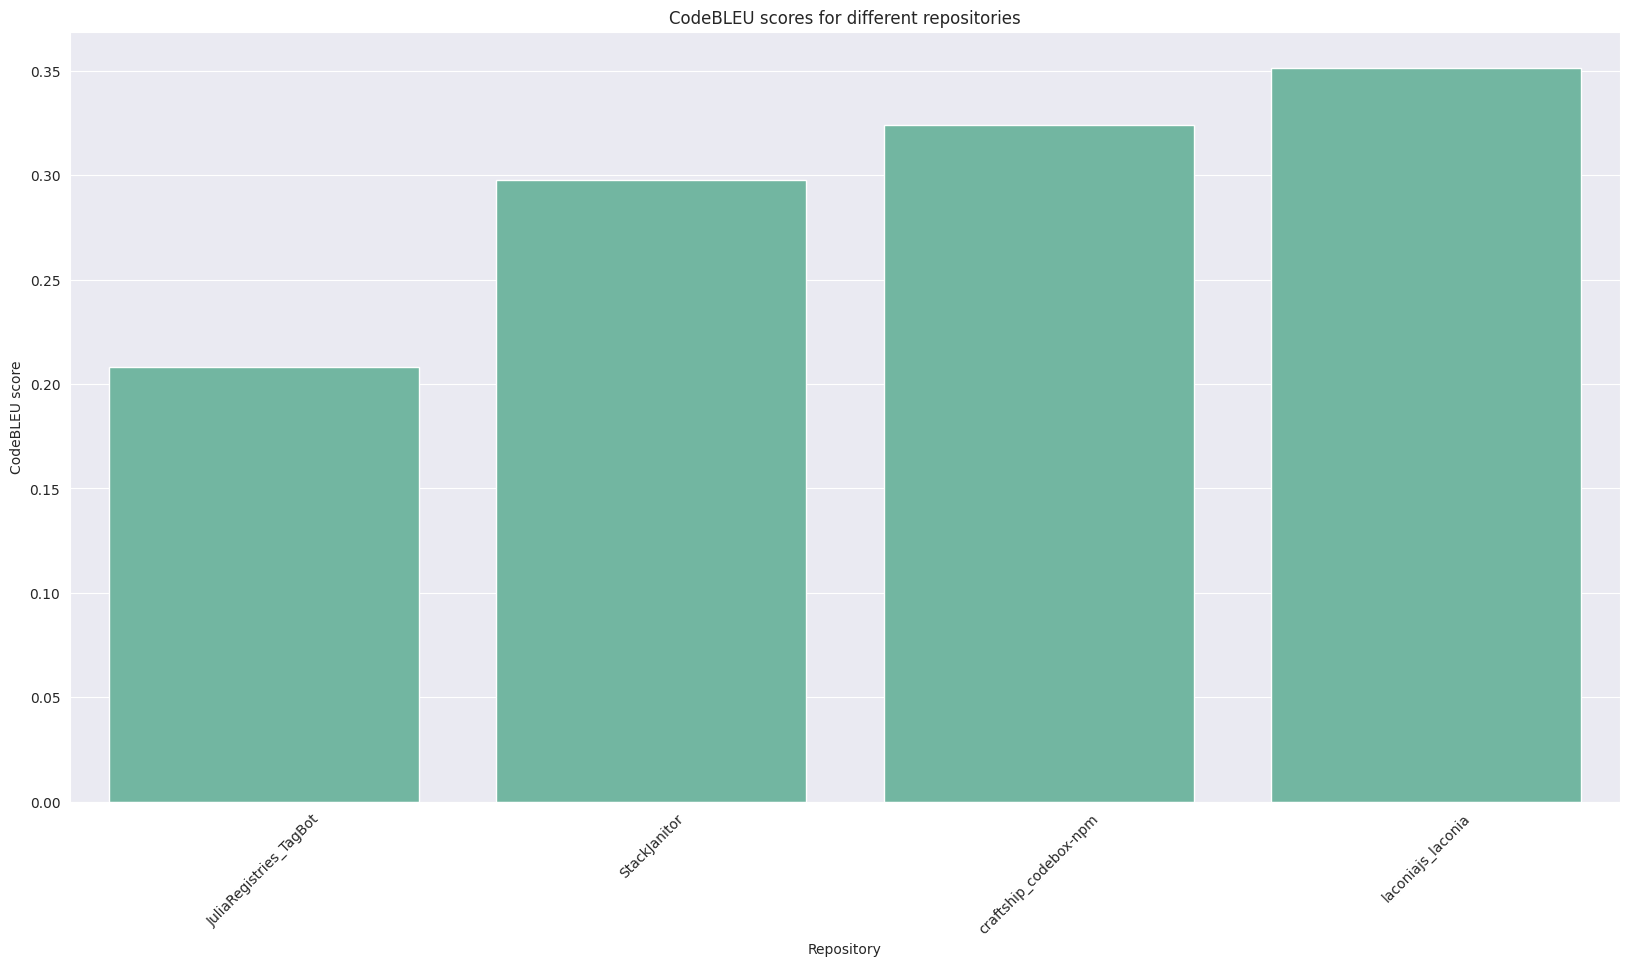

In [63]:
plt.figure(figsize=(20, 10))
average_codebleu_scores = codebleu_scores_df.groupby("Repo", as_index=False)["CodeBLEU"].mean()

sns.barplot(x="Repo", y="CodeBLEU", data=average_codebleu_scores)

plt.title("CodeBLEU scores for different repositories")
plt.xlabel("Repository")
plt.ylabel("CodeBLEU score")
plt.xticks(rotation=45)
plt.show()

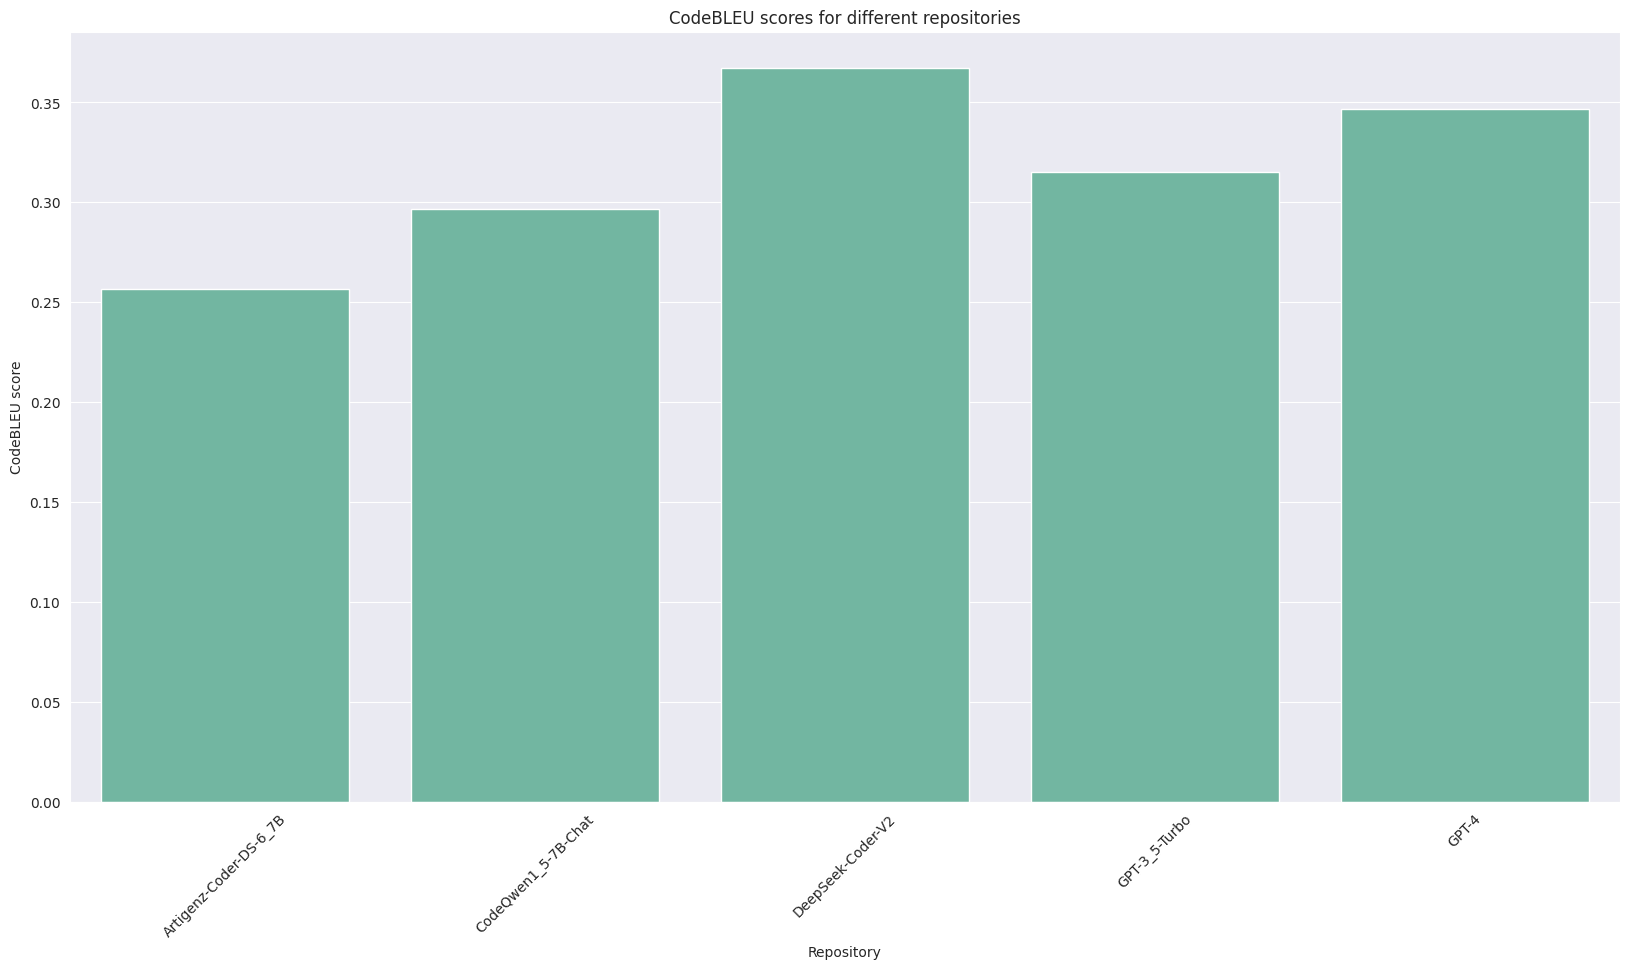

In [67]:
plt.figure(figsize=(20, 10))
average_codebleu_scores = codebleu_scores_df.groupby("Model", as_index=False)["CodeBLEU"].mean()

sns.barplot(x="Model", y="CodeBLEU", data=average_codebleu_scores)

plt.title("CodeBLEU scores for different repositories")
plt.xlabel("Repository")
plt.ylabel("CodeBLEU score")
plt.xticks(rotation=45)
plt.show()

In [12]:
plt.rcParams['font.family'] = 'serif'

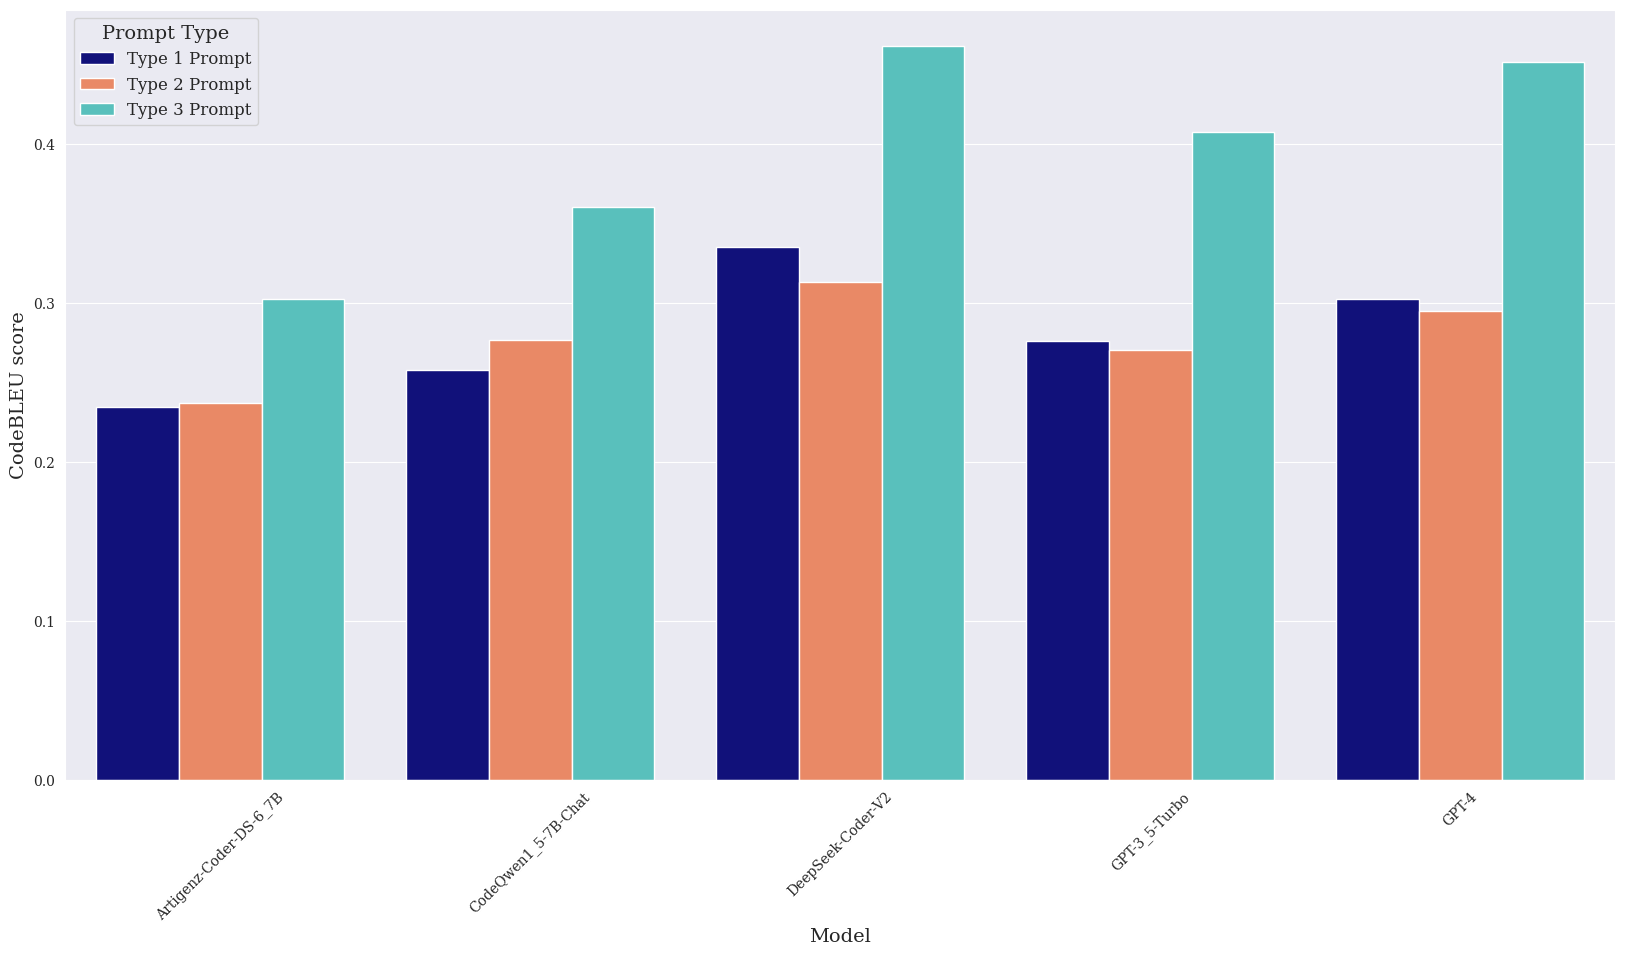

In [20]:
plt.figure(figsize=(20, 10))

average_codebleu_scores = codebleu_scores_df.groupby(["Model", "PromptType"], as_index=False)["CodeBLEU"].mean()

# sns.barplot(x="Model", y="CodeBLEU", hue="PromptType", data=average_codebleu_scores)
# change hue colours
sns.barplot(x="Model", y="CodeBLEU", hue="PromptType", data=average_codebleu_scores, palette=["darkblue", "coral", "mediumturquoise"])

# plt.title("CodeBLEU scores for different models and prompt types", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("CodeBLEU score", fontsize=14)
plt.xticks(rotation=45)

# change legend title and labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Type 1 Prompt", "Type 2 Prompt", "Type 3 Prompt"]
plt.legend(title="Prompt Type", labels=labels, handles=handles, fontsize=12, title_fontsize=14)
plt.savefig(f"plots/CodeBLEU Scores.png", dpi=600, bbox_inches='tight')
plt.show()


In [1]:
# Calculate average CodeBLEU scores by Model and PromptType
average_codebleu_scores = codebleu_scores_df.groupby(["Model", "PromptType"], as_index=False)["CodeBLEU"].mean()

# Extract unique models and prompt types
models = average_codebleu_scores["Model"].unique()
prompt_types = average_codebleu_scores["PromptType"].unique()

# Define bar width and positions for grouped bars
bar_width = 0.2
x = np.arange(len(models))

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each prompt type
colors = ["darkblue", "coral", "mediumturquoise"]
for i, prompt_type in enumerate(prompt_types):
    # Filter data for the current prompt type
    data = average_codebleu_scores[average_codebleu_scores["PromptType"] == prompt_type]
    
    # Plot bars for the current prompt type
    ax.bar(x + i * bar_width, data["CodeBLEU"], width=bar_width, label=f"Prompt Type {i + 1}", color=colors[i])

# Set title and labels
ax.set_title("CodeBLEU Scores for Different Models and Prompt Types", fontsize=16)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("CodeBLEU Score", fontsize=14)
ax.set_xticks(x + bar_width * (len(prompt_types) - 1) / 2)
ax.set_xticklabels(models, rotation=45)
ax.set_ylim(0, 1)

# Customize the legend
ax.legend(title="Prompt Type", fontsize=12, title_fontsize=14)

# Save and display the plot
# plt.savefig("plots/CodeBLEU_Scores.png", dpi=600, bbox_inches="tight")
plt.show()


NameError: name 'codebleu_scores_df' is not defined

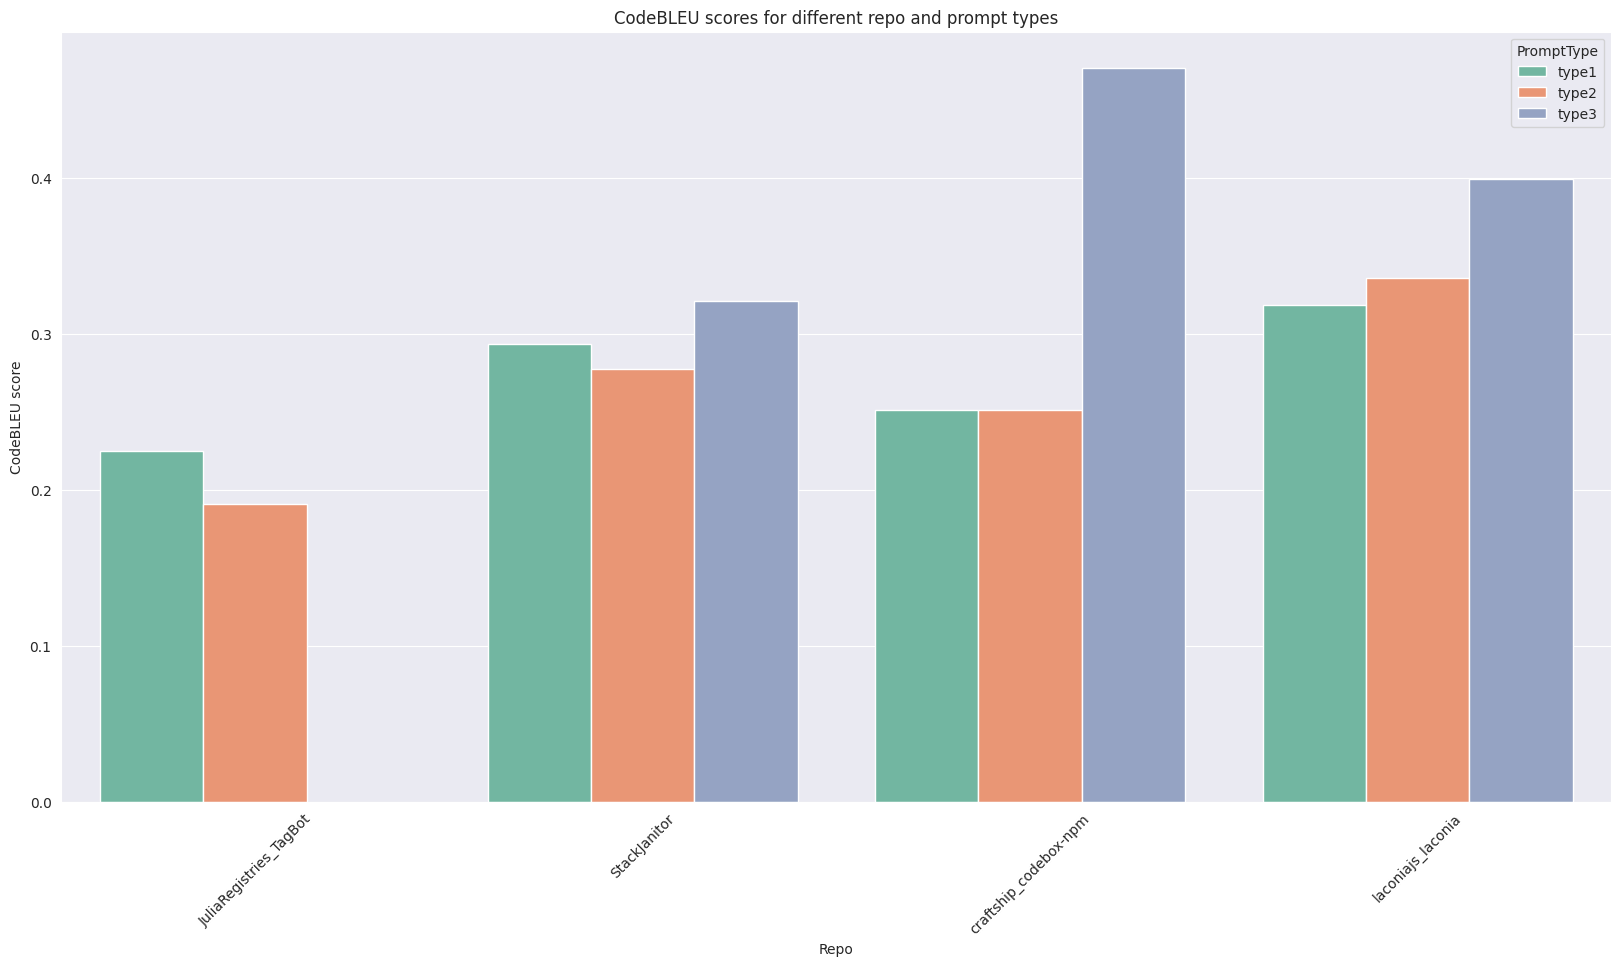

In [66]:
plt.figure(figsize=(20, 10))

average_codebleu_scores = codebleu_scores_df.groupby(["Repo", "PromptType"], as_index=False)["CodeBLEU"].mean()

sns.barplot(x="Repo", y="CodeBLEU", hue="PromptType", data=average_codebleu_scores)

plt.title("CodeBLEU scores for different repo and prompt types")
plt.xlabel("Repo")
plt.ylabel("CodeBLEU score")
plt.xticks(rotation=45)
plt.show()
